In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
# import albumentations as A # Library for augmentations
import os
import cv2
import json
import time
import random
import argparse
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

#Very hacky fix to make matplotlib work on my pc
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"

### Hyperparameters
batch_size = 3

In [2]:
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        # transforms = []
       
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        # img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        

        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor)
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img)      

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))


filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=False, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

# Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

batch[0] list containing 3 tensors of shape torch.Size([3, 640, 640]):
batch[1] list containing 3 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


In [3]:
model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
#count parameters
print(f'Model has {sum(p.numel() for p in model.parameters()):,} parameters')

Model has 59,137,258 parameters


In [4]:
model

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [5]:
model.eval()
preds = model(batch[0])

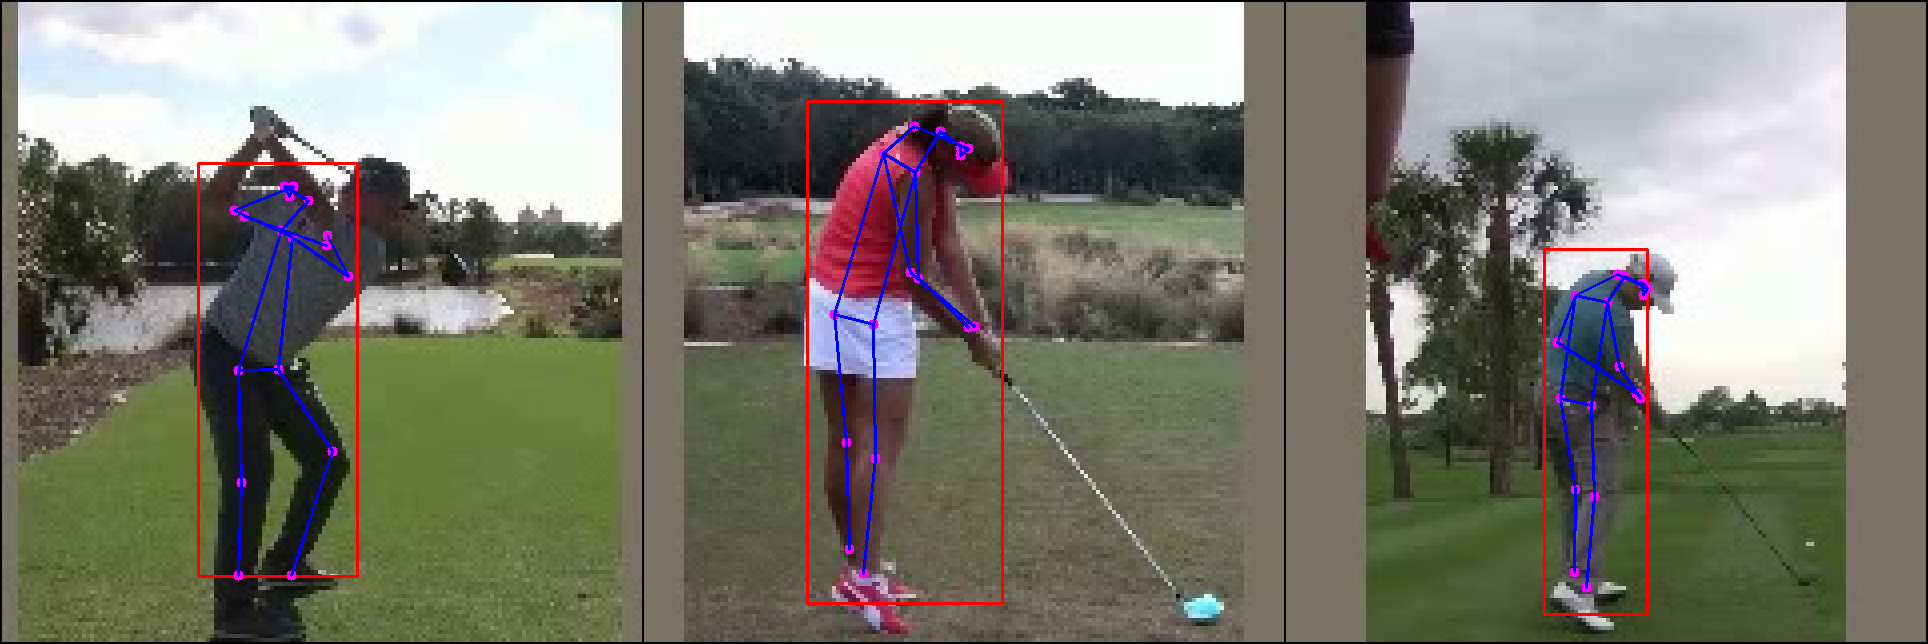

In [6]:
labelled_imgs = []
for i in range(len(preds)):
    input_img = batch[0][i]
    pred = preds[i]
    box = [int(x) for x in pred["boxes"][0].detach()]
    keypoints = [[int(x[0]), int(x[1])]  for x in pred["keypoints"][0].detach()]
    img = (input_img.permute(1,2,0).numpy()*255).astype(np.uint8)[:, :, ::-1]
    
    skeleton =  [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],
                [6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]

    labelled = img.copy()
    cv2.rectangle(labelled, box[:2], box[2:], (0, 0, 255), 2)
    for keypoint in keypoints:
        cv2.circle(labelled, tuple(keypoint), 5, (255,0,255), -1)

    for pair in skeleton:
        cv2.line(labelled, keypoints[pair[0]-1], keypoints[pair[1]-1], (255, 0, 0), 2)

    labelled_imgs.append(torch.Tensor(labelled[:, :, ::-1]/255.))
    # display( Image.fromarray(labelled[:, :, ::-1]))

Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_imgs,dim=0).permute(0,3,1,2), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [7]:
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out

batch = next(iter(dataloader))
model.train()
metrics = model(*batch)
metrics

{'loss_classifier': tensor(0.1850, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0726, grad_fn=<DivBackward0>),
 'loss_keypoint': tensor(9.5198, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.1121, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0075, grad_fn=<DivBackward0>)}

[196, 161, 355, 574] [[355, 329], [210, 493]]
[163, 99, 358, 601] [[326, 359], [222, 304]]
[258, 247, 361, 612] [[361, 435], [267, 515]]


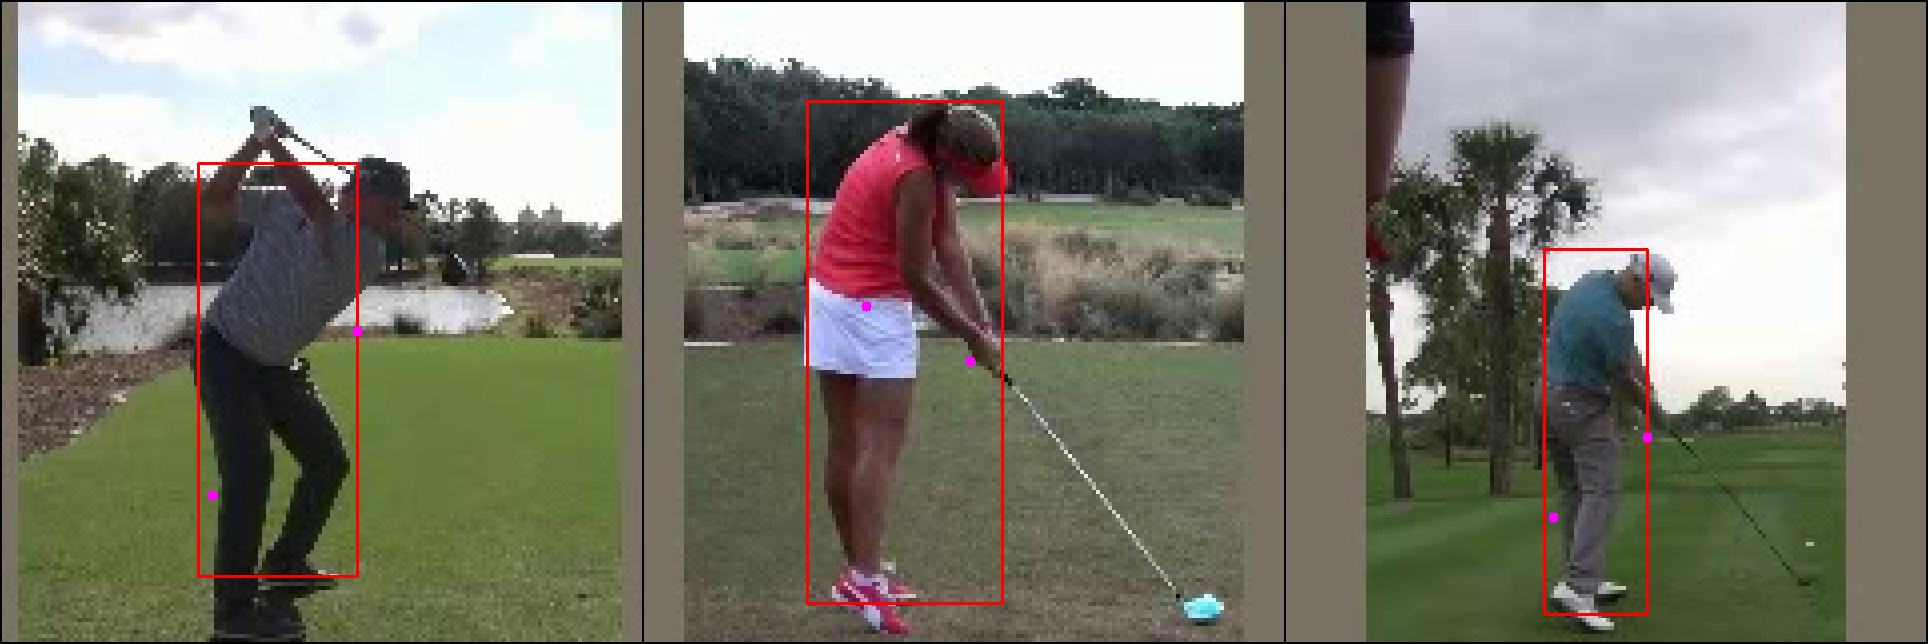

In [8]:
model.eval()
preds = model(batch[0])

labelled_imgs = []
for i in range(len(preds)):
    input_img = batch[0][i]
    pred = preds[i]
    box = [int(x) for x in pred["boxes"][0].detach()]
    keypoints = [[int(x[0]), int(x[1])]  for x in pred["keypoints"][0].detach()]
    print(box, keypoints)

    img = (input_img.permute(1,2,0).numpy()*255).astype(np.uint8)[:, :, ::-1]
    labelled = img.copy()
    cv2.rectangle(labelled, box[:2], box[2:], (0, 0, 255), 2)
    cv2.circle(labelled, keypoints[0], 5, (255,0,255), -1) # handle
    cv2.circle(labelled, keypoints[1], 5, (255,0,255), -1) # club head
    labelled_imgs.append(torch.Tensor(labelled[:, :, ::-1]/255.))
    # display( Image.fromarray(labelled[:, :, ::-1]))

Image.fromarray((torchvision.utils.make_grid(torch.stack(labelled_imgs,dim=0).permute(0,3,1,2), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [10]:
batch_size = 1
filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=False, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
batch = next(iter(dataloader))

model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
print(f'Model has {sum(p.numel() for p in model.parameters()):,} parameters')

Model has 59,137,258 parameters


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 1
lr = 0.002
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

t_start = time.time()
model.train()
for epoch in range(epochs):
    for i, (images, targets) in enumerate(dataloader): 
        if i > 5:
            break

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        #forward pass takens 1/3 of time, backward pass takes 2/3 of time
        print(f"[{i+1}/{len(dataloader)}] Loss: {losses.item():.4f}, time taken: {time.time()-t_start:.1f} {[f'{k}: {v.item():.3f}' for k, v in loss_dict.items()]}")

loss generated: 5.3
losses backward: 16.2
optimizer step: 17.5
[1/64] Loss: 13.9164, time taken: 17.5 ['loss_classifier: 0.103', 'loss_box_reg: 0.101', 'loss_keypoint: 13.614', 'loss_objectness: 0.083', 'loss_rpn_box_reg: 0.016']
loss generated: 21.6
losses backward: 28.9
optimizer step: 29.6
[2/64] Loss: 48.1759, time taken: 29.6 ['loss_classifier: 5.030', 'loss_box_reg: 2.550', 'loss_keypoint: 38.677', 'loss_objectness: 1.781', 'loss_rpn_box_reg: 0.139']
loss generated: 33.3
losses backward: 41.5
optimizer step: 43.1
[3/64] Loss: 34.5712, time taken: 43.1 ['loss_classifier: 1.168', 'loss_box_reg: 0.235', 'loss_keypoint: 26.025', 'loss_objectness: 7.134', 'loss_rpn_box_reg: 0.009']
loss generated: 52.2
losses backward: 66.1
optimizer step: 67.2
[4/64] Loss: 530.8499, time taken: 67.2 ['loss_classifier: 1.021', 'loss_box_reg: 3.735', 'loss_keypoint: 523.979', 'loss_objectness: 1.828', 'loss_rpn_box_reg: 0.288']


KeyboardInterrupt: 